In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

In [7]:
date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time)
data = [1, 2, 3]

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

C:\Users\Sihao\AppData\Local\Temp\ipykernel_17840\3145200655.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\Sihao\AppData\Local\Temp\ipykernel_17840\3145200655.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


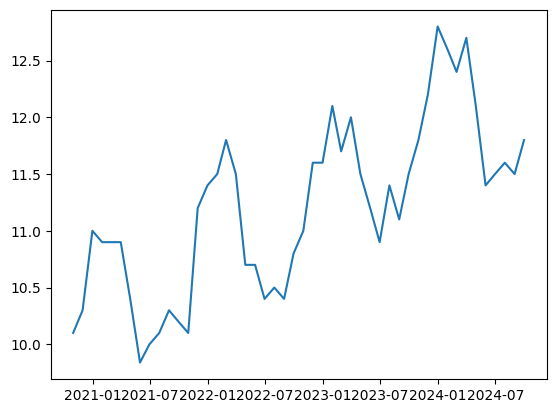

In [3]:
fig, ax = plt.subplots()
ax.plot(dates, prices, '-')
plt.show()

In [6]:
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1

while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)

    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
            
days_from_start = [(day - start_date).days for day in months]

In [9]:
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

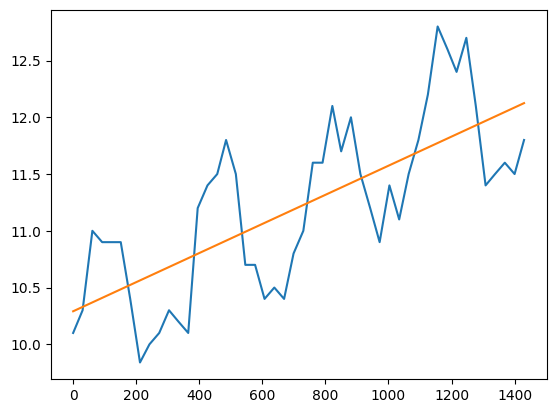

In [10]:
time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.show()

In [11]:
# observe it does not fit intra-year variations, so we must use bilinear regression
# we use bilinear regression to solve for u = Acos(z), w = Asin(z) with no intercept

In [13]:
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

In [14]:
def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return (slope1, slope2)

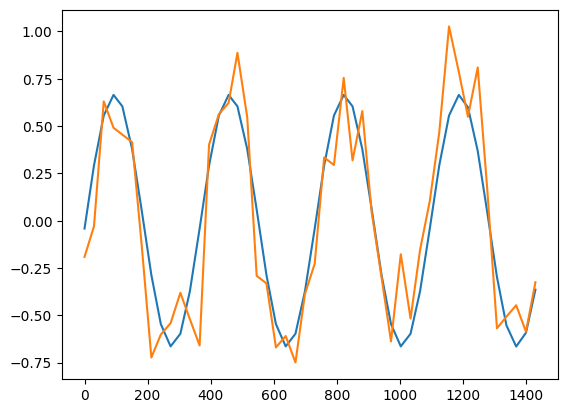

In [15]:
slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.show()

In [16]:
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        return prices[days_from_start.index(days)]
    else: 
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

In [17]:
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

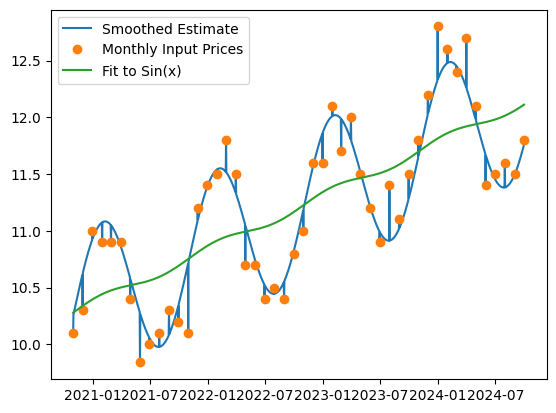

In [21]:
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))

plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sin(x)')

plt.legend()
plt.show()